In [16]:
try:
    from xcube_sh.sentinelhub import SentinelHub
    from sentinelhub import BBox, WmsRequest, DataSource, SHConfig
    from xcube_sh.observers import Observers
    from xcube_sh.config import CubeConfig
    from xcube_sh.cube import open_cube
except ModuleNotFoundError:
    pass

from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA
from sklearn import preprocessing

import pandas as pd
# from edc import setup_environment_variables
from os import environ
import xarray as xr
from pyproj import Transformer
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from itertools import combinations
import IPython.display
import shapely.geometry
import rioxarray
import time
from zarr.errors import GroupNotFoundError

In [2]:
# bbox = (-3.93, 52.56, -3.9, 52.58)
# bbox = (32,  31.1, 32.1, 31.2) # Middle East
bbox = (-3.93, 52.56, -3.9, 52.58) 
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

In [3]:
# !rm -r data/*.zarr

In [4]:
# time_range = ['2021-06-01', '2021-06-30']
# spatial_res = 4*0.00018   # = 10.038 meters in degree>
# cube_config = CubeConfig(dataset_name='S2L2A',
#                          band_names=['B02', 'B03', 'B04', 'CLM'],
#                          #tile_size=[512, 512],
#                          bbox=bbox,
#                          spatial_res=spatial_res,
#                          time_range=time_range,
#                          time_period='1D')

# request_collector = Observers.request_collector()
# try:
#     cube = xr.open_zarr('data/cube1.zarr')
# except GroupNotFoundError:
#     cube = open_cube(cube_config, observer=request_collector)
#     cube.to_zarr('data/cube1.zarr')
# # cube = cube.rename(lon='x', lat='y')

# filt = np.logical_not(np.isnan(cube['B02']).all(dim=('lon', 'lat')))
# cube = cube.where(filt, drop=True)
# # cube
# cube = cube.where(np.logical_not(np.isnan(cube)), cube.mean(dim=('time')))

# cube = cube.mean(dim='time')

# cube['B02'] = cube['B02'].where(np.isnan(cube['B02']).mean(dim=('lon', 'lat')))

In [14]:
band_names = [f'B0{i}' for i in range(2, 10) if i != 9] + ['B8A', 'CLM', 'SCL']
print(band_names)

spatial_res = 1*0.00018   # = 10.038 meters in degre

def get_cloud_free(time_range):
    fname = f'data/{time_range[0]}_{time_range[1]}.zarr'
    try:
        cube = xr.open_zarr(fname)
    except (NameError, GroupNotFoundError):
        spatial_res = 0.00018   # = 10.038 meters in degree>
        cube_config = CubeConfig(dataset_name='S2L2A',
                                 band_names=band_names,
                                 #tile_size=[512, 512],
                                 bbox=bbox,
                                 spatial_res=spatial_res,
                                 time_range=time_range,
                                 time_period='1D')

        request_collector = Observers.request_collector()
        cube = open_cube(cube_config, observer=request_collector)
        cube.to_zarr(fname)
    # cube = cube.rename(lon='x', lat='y')

    filt = np.logical_not(np.isnan(cube['B02']).all(dim=('lon', 'lat')))
    cube = cube.where(filt, drop=True)
    cube = cube.where(np.logical_not(cube.CLM))
    # cube
    cube = cube.mean(dim='time')
#     cube = cube.where(np.logical_not(np.isnan(cube)), 0)
    return cube
# cube = cube.where(np.logical_not(np.isnan(cube)), cube.mean(dim=('time')))
band_names

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'CLM', 'SCL']


['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'CLM', 'SCL']

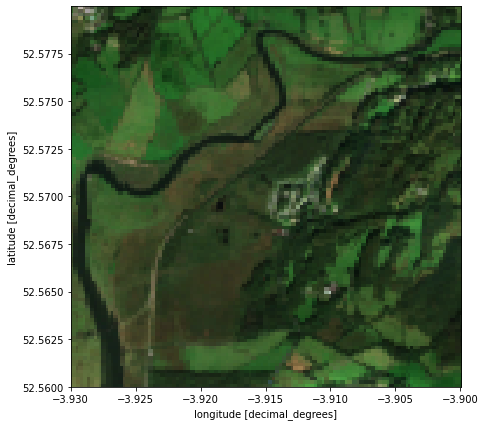

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


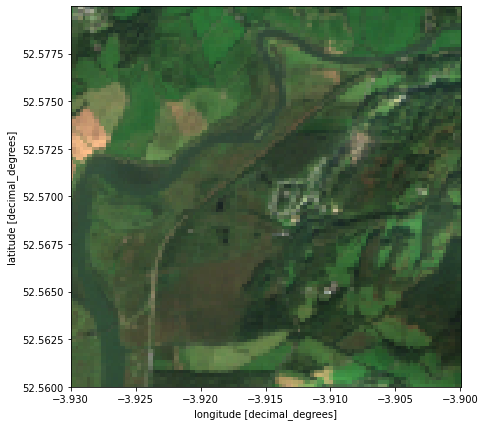

In [15]:
d1, d2 = '2019-09-20', '2020-09-21'
time_range = [d1, d1]
ds_a = get_cloud_free(time_range)
time_range = [d2, d2]
ds_b = get_cloud_free(time_range)
ds = xr.concat([ds_a, ds_b], dim='time')

from sklearn.preprocessing import scale

# def rescale(X):
#     X = X.where(np.isfinite(X))
#     Xmax = X.max()*0.8
#     Xmin = X.min()*1.2
#     return ((X - Xmin) * (1/(Xmax - Xmin) * 1))#.astype('uint8')

def rescale(X):
    return 6*X

# size = 128
# ds = ds.isel(lat=slice(0, 64), lon=slice(0, size))
# ds_a = ds_a.isel(lat=slice(0, 64), lon=slice(0, size))
# ds_b = ds_b.isel(lat=slice(0, 64), lon=slice(0, size))

for t, ds0 in ds.groupby('time'):
    r, g, b = 'B04', 'B03', 'B02'
    cube_rgb = xr.concat([rescale(ds0[r]), rescale(ds0[g]), rescale(ds0[b])], 'band')
    cube_rgb.rio.to_raster(f"plots/{t}.tif")
    cube_rgb.plot.imshow(rgb='band', figsize=(7, 7))
    plt.show()

In [ ]:
v = 'B03'
plt.hist2d(ds_a[v].values.ravel(), ds_b[v].values.ravel(), bins=1000)
plt.show()

In [ ]:
ds_a['SCL'].plot.imshow()
plt.show()
ds_b['SCL'].plot.imshow()
plt.show()

In [ ]:
# time_range = ['2020-07-17', '2020-07-17']
# ds_202106 = get_cloud_free(time_range)

# time_range = ['2020-11-14', '2020-11-14']
# ds_202006 = get_cloud_free(time_range)
ds_a = ds_a.fillna(0)
ds_b = ds_b.fillna(0)

components_list = []
for v in ds_a.variables:
    print(v)
    if not v.startswith('B'):
        continue
    ds = xr.concat([ds_a, ds_b], dim='time')
    da_z= ds[v].stack(z=('lon', 'lat'))
    pca = SparsePCA(alpha=.1, tol=1e-4, max_iter=20, method='lars', n_jobs=-1)
#     pca = PCA()
    weights = pca.fit_transform(da_z.isel(time=[0, 1]).T)
    da_z = xr.DataArray(weights, dims=da_z.dims, name=v)
    components_list.append(da_z)
components = np.array(components_list)

In [ ]:
for c in range(8):
    fig, axs = plt.subplots(1, 2)
    for i in range(2):
        vmax = np.quantile(components[c,:,i], 0.99)
        print(vmax)
        axs[i].imshow(components[c,:,i].reshape(len(ds.lon), len(ds.lat)).T, vmax=vmax)
    plt.show()

In [ ]:
# for c in range(8):
#     plt.hist2d(components[c,:,0], components[c,:,1],bins=1000)
#     plt.show()

In [ ]:
def get_1d(time):
    dd = ds.isel(time=time)
    return xr.concat([dd[v] for v in dd], 'band').stack(z=['lon', 'lat']).transpose('z', 'band')

a = get_1d(0)
b = get_1d(1)

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, AffinityPropagation, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

def weights_of_diff_pca(corr_diff):
#     pca = PCA(n_components=5)
#     pca_comp_weights = pca.fit_transform(components[:, :, corr_diff].T)
    pca_comp_weights = components[:, :, corr_diff].T
    scaler = StandardScaler()
    pca_comp_weights = scaler.fit_transform(pca_comp_weights)
    return pca, pca_comp_weights # / np.sqrt((pca_comp_weights**2).sum(axis=0))

pca0, pca_comp_weights0 = weights_of_diff_pca(0)
pca1, pca_comp_weights1 = weights_of_diff_pca(1)

da_weights0 = xr.DataArray(pca_comp_weights0, dims=('z', 'band'))
da_weights1 = xr.DataArray(pca_comp_weights1, dims=('z', 'band'))

ds_diff = xr.Dataset(data_vars=dict(weights0=da_weights0, weights1=da_weights1))

def norm(x):
    return x / np.sqrt((x**2).sum())  

weights1_pwr = np.sqrt((ds_diff.weights1**2).sum(dim='band'))
# ds_diff = ds_diff.where( weights1_pwr > np.quantile(weights1_pwr, 0.95))

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# for v in ['weights0', 'weights1']:
#     ds_diff[v] = (ds_diff[v].dims, scaler.fit_transform(ds_diff[v]))

In [ ]:
plt.hist(np.concatenate([pca_comp_weights0.ravel(), pca_comp_weights1.ravel()]), bins=1000)
plt.show()

In [ ]:
plt.hist(np.sqrt((pca_comp_weights0**2).sum(axis=1)), bins=200, alpha=1)
# plt.hist(np.sqrt((pca_comp_weights1**2).sum(axis=1)), bins=200, alpha=0.25)
plt.show()

In [ ]:
np.abs(ds_diff['weights0'].mean(dim='band')).plot.hist(bins=1000)
plt.show()

In [ ]:
for (b0, d0), (b1, d1) in zip(*(ds_diff['weights1'].groupby('band'), ds_diff['weights1'].groupby('band'))):
    d0.plot.hist(bins=1000, alpha=1)
#     d1.plot.hist(bins=1000, alpha=0.75)
    plt.show()

Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted. If “precomputed”, a distance matrix (instead of a similarity matrix) is needed as input for the fit method.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
X = ds_diff['weights1']
transformer = FastICA(n_components=1, whiten=True, random_state=0)
X_transformed = transformer.fit_transform(X)

In [ ]:
a = np.sqrt((ds_diff['weights1']**2).sum(axis=1)).values.reshape(len(ds.lon), len(ds.lat)).T
plt.imshow(a**2, vmin=np.quantile(a, 0.90), vmax=np.quantile(a, 0.9999))
plt.show()

In [ ]:
plt.figure(dpi=120)
plt.imshow(a)

In [ ]:
clustering = 'kmeans'

if clustering == 'gmm':
    def get_cluster_labels(weights, components=20):
    #     weights = weights.isel(z=slice(None, None, 10))
    #     pca = PCA(n_components=8)
    #     weights = pca.fit_transform(weights) 
        weights_small = weights.isel(z=slice(None, None, 10))
        mix = GaussianMixture(n_components=components)
        mix.fit(weights_small)
        return mix, mix.predict(weights)

elif clustering == 'kmeans':
    def get_cluster_labels(weights, components=20):
#         weights_small = weights.isel(z=slice(None, None, 10))
        cluster = KMeans(n_clusters=components)
        cluster.fit(weights)
        return cluster, cluster.labels_

# N = 30
# mix0, labels0 = get_cluster_labels(ds_diff['weights0'], N)
# mix1, labels1 = get_cluster_labels(ds_diff['weights1'], N)

ds_diff['labels0'] = ('z', ), labels0
ds_diff['labels1'] = ('z', ), labels1

X = np.stack((ds_diff['labels0'], ds_diff['labels1']), axis=-1) 
le = preprocessing.LabelEncoder()
ds_diff['combined'] =  ('z', ),  np.array(le.fit_transform([str(x[0]) + str(x[1]) for x in X]))

if clustering == 'gmm':
    m = np.sqrt((mix1.means_**2).sum(axis=1))
    cov = mix1.covariances_
    s = np.array([np.sqrt(np.trace(cov[i])/N) for i in range(0, N)])
elif clustering == 'kmeans':
    m = np.sqrt((mix1.cluster_centers_**2).sum(axis=1))

    
ds_diff['filter'] =  ('z', ), np.logical_or.reduce([(ds_diff['labels1'] == i[0]) for 
                                                     i in np.argwhere(m > 2.5 * np.quantile(m, 0.1))])

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
for i, v in enumerate(('combined', )): 
    labels, counts = np.unique(ds_diff[v], return_counts=True)
    da = ds_diff[v]
    da = da.where(ds_diff['filter'])    
    da_img = da.values.reshape(len(ds.lon), 
                               len(ds.lat)).T
    da_img = xr.DataArray(da_img, dims=ds_a.dims , coords=ds_a.coords)
    da_img.rio.to_raster(f"plots/{v}.tif")
    da_img.plot.imshow(ax=axs, cmap='Set1')
plt.show()

In [ ]:
ds_diff

In [ ]:
plt.hist(m, bins=10)
plt.show()

In [ ]:
m = np.sqrt((mix1.means_**2).sum(axis=1))
for i in np.argwhere(m > 2):
    ds_diff['filter'] = ('z', ),  ds_diff['labels1'] == i 

In [ ]:
plt.hist((mix1.predict_proba(ds_diff['weights1'])**2).sum(axis=1), bins=100)
plt.show()

In [ ]:
ds_diff['filter']

In [ ]:
l, c = np.unique(ds_diff['labels1'], return_counts=True)
list(zip(*sorted(zip(*(l, c)), key=lambda i: i[1], reverse=True)))

In [ ]:
import scipy

In [ ]:
centers = np.empty(shape=(mix1.n_components, ds_diff['weights1'].values.shape[1]))
for i in range(mix1.n_components):
    density = scipy.stats.multivariate_normal(cov=mix1.covariances_[i], mean=mix1.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import mixture

n_samples = 100
C = np.array([[0.8, -0.1], [0.2, 0.4]])

X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
         np.random.randn(n_samples, 2) + np.array([-2, 1]), 
         np.random.randn(n_samples, 2) + np.array([1, -3])]

gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(X)

plt.scatter(X[:,0], X[:, 1], s = 1)

centers = np.empty(shape=(gmm.n_components, X.shape[1]))
for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
plt.scatter(centers[:, 0], centers[:, 1], s=20)
plt.show()

In [ ]:
cov = mix1.covariances_
N = 20
s = np.array([np.sqrt(np.trace(cov[i])/N) for i in range(0, N)])
m = np.sqrt((mix1.means_**2).sum(axis=1))
plt.scatter(m, s)
plt.grid()
plt.show()

In [ ]:
m[9]

In [ ]:
plt.hist(mix1.means_.mean(axis=1))
plt.grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))
for i, v in enumerate(('labels0', 'labels1', 'combined')): 
    labels, counts = np.unique(ds_diff[v], return_counts=True)
    if v == 'combined':
#         args = np.argwhere(np.logical_or(counts < 1000, counts == counts.max())).ravel()
#         for a in args:
#             ds_diff[v] = ds_diff[v].where(ds_diff[v] != labels[a])
        da = ds_diff[v]
    else:
#         da = ds_diff[v]
        da = ds_diff[v]#.where(ds_diff[v] != labels[np.argmax(counts)])
    da_img = da.values.reshape(len(ds.lon), 
                               len(ds.lat)).T
    da_img = xr.DataArray(da_img, dims=ds_a.dims , coords=ds_a.coords)
#     da_img.rio.to_raster(f"plots/{v}.tif")
    da_img.plot.imshow(ax=axs[i], cmap='Set2')
plt.show()

In [ ]:
get_cluster_labels(ds_diff['weights0'].fillna(0).isel(z=slice(0, None)))

In [ ]:
da_img = xr.DataArray(da_img, dims=ds_a.dims , coords=ds_a.coords)
da_img

In [ ]:
ds_diff

In [ ]:
ds['labels1'] = ('lat', 'lon'), ds_diff['labels1'].values.reshape(len(ds.lon), len(ds.lat)).T

def get_mean(t, label, stat):
    filt = ds['labels1'] == label
    return np.array([(getattr(ds[v].isel(time=t).where(filt), stat)(skipna=True).values) for v in ds.variables if v.startswith('B')])

labels = np.unique(ds['labels1'])
# labels = labels[~np.isnan(labels)]
print(labels)

labels_sorted, m_ = list(zip(*sorted(zip(*(labels, m)), key=lambda i: i[1], reverse=True)))

for l in labels_sorted:
    plt.errorbar(range(8), get_mean(0, l, 'mean'), yerr=get_mean(0, l, 'std'))
    plt.errorbar(np.arange(8) + 0.05, get_mean(1, l, 'mean'), yerr=get_mean(1, l, 'std'))
    plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
for i in range(2):
    ds_diff[f'diffs{i}'] = ('band', 'z'), components[:,:,i]

In [ ]:
ds_diff.diffs0.where()

In [ ]:
rm plots/*.*

In [ ]:
args = np.argwhere(np.logical_and(counts > 1000, counts != counts.max())).ravel()
args

In [ ]:
np.array(le.fit_transform([str(x[0]) + str(x[1]) for x in X]))

In [ ]:
def create_plots(pca_comp_weights, only_one, threshold):
#     for c in combinations(range(8), 3):
    
    for c in range(8):
        fig, ax = plt.subplots()
        c = (c, c, c) 
        ds_comp = xr.DataArray(((pca_comp_weights[:, c]**2)).reshape(len(ds.lon), len(ds.lat), 3).T, dims=('comp','lat', 'lon'))
        ds_comp = ds_comp.reindex(lat=ds_comp.lat[::-1])
        vmax = np.quantile(ds_comp.values.ravel(), threshold)
#         comps_str = "".join(str(i) for i in c)
        np.abs(ds_comp).plot.imshow(rgb='comp', vmin=vmax/100, vmax=vmax, alpha=1, ax=ax)
#         np.abs(ds_comp.isel(comp=0)).plot.contour(ax=ax)

#         plt.title(comps_str)
#         plt.show()
    #     plt.savefig(f'plots/{comps_str}') 
#         plt.close()
        plt.show()
        if only_one:
            break
            
# create_plots(pca_comp_weights0, True, .95)
create_plots(pca_comp_weights1, False, .999)

In [ ]:
plt.plot(pca_co_weights0[200])
plt.show()

In [ ]:
def create_plots(pca_comp_weights0_, pca_comp_weights1_, only_one, threshold):
    global alpha
#     for c in combinations(range(8), 3):    
    ds_comp0 = xr.DataArray(((pca_comp_weights0_[:,  (0, 1, 2)]**2)).reshape(len(ds.lon), len(ds.lat), 3).T, dims=('comp', 'lat', 'lon'))
    ds_comp0 = ds_comp0.reindex(lat=ds_comp0.lat[::-1]) 
    for c in range(8):
        fig, ax = plt.subplots()    
        ds_comp1 = xr.DataArray(((pca_comp_weights1_[:, (c, c, c)]**2)).reshape(len(ds.lon), len(ds.lat), 3).T, dims=('comp', 'lat', 'lon'))
        ds_comp1 = ds_comp1.reindex(lat=ds_comp1.lat[::-1])
        vmax = np.quantile(ds_comp1.values.ravel(), threshold)

#         comps_str = "".join(str(i) for i in c)
        alpha = 1*ds_comp1.isel(comp=0)/ds_comp1.isel(comp=0).max()
        (alpha.expand_dims(band=3)*cube_rgb).plot.imshow(rgb='band', 
                             alpha=alpha, 
#                              vmin=vmax/100, vmax=vmax, ax=ax
                                    )
#         np.abs(ds_comp.isel(comp=0)).plot.contour(ax=ax)

#         plt.title(comps_str)
#         plt.show()
    #     plt.savefig(f'plots/{comps_str}') 
#         plt.close()
        plt.show()
        if only_one:
            break
       
            
# create_plots(pca_comp_weights0, True, .95)
create_plots(pca_comp_weights0, pca_comp_weights1, False, .95)

In [ ]:
cube_rgb = cube_rgb.compute()

In [ ]:
cube_rgb.where(alpha)

In [ ]:

da = xr.DataArray(components, dims=('band', 'z', 'comp'))
da_z = da.stack(zz=('comp', 'band'))#.transpose('zz', 'band')
da_z

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
kmeans = KMeans(n_clusters=30, random_state=0).fit(da_z)

In [ ]:
def norm(x):
    x = x/np.sqrt((x**2).sum())
    x -= x.min()
    return x

for c in kmeans.cluster_centers_:
    plt.plot(norm(c[:8]))
    plt.plot(norm(c[8:]))
    plt.show()
    break

In [ ]:
ds_z = da_z.to_dataset(name='weights')
ds_z['labels'] = kmeans.labels_
plt.imshow(ds_z.unstack()['labels'].values.reshape(len(ds.lon), len(ds.lat)).T)
plt.show()

In [ ]:
x = (np.abs(ds_comp)).max(dim='comp')
# vmax = np.quantile(x.values.ravel(), .99)
vmin = np.quantile(x.values.ravel(), .98)
(x > vmin).plot.imshow(figsize=(10, 10))
plt.show()

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
plt.plot(pca.components_[0])
plt.show()

In [ ]:
def get_comp2d(c):
    return xr.DataArray(components[:,:,c].prod(axis=0).reshape(len(ds.lon), len(ds.lat)).T, dims=('lon', 'lat'))

for i in range(2):
    d = np.abs(get_comp2d(i))
    d = d / d.sum()
    plt.imshow(d, vmin=0, vmax=np.quantile(d.values.ravel(), .98))
    plt.show()

In [ ]:
d_rgb = xr.concat([get_comp2d(1), get_comp2d(0), get_comp2d(0)], 'band')
d_rgb.plot.imshow(rgb='band')
plt.show()

In [ ]:
d = get_comp2d(0)*(10**9)*get_comp2d(1)
plt.imshow(d, vmax=np.quantile(d.ravel(), .99))
plt.show()

In [ ]:
plt.hist(d.ravel(), bins=1000)
# plt.xlim(-0.01, 0.01)
plt.show()

In [ ]:
d = np.abs(pca.components_[1].reshape(len(ds.lon), len(ds.lat)))**1
plt.imshow(d.T, vmin=0, vmax=np.quantile(d,.99))
plt.show()

In [ ]:
ds

In [ ]:
da_z['components'] = (() pca.components_[0])

In [ ]:
pca.components_[0]

In [ ]:
cube_z.isel(time=[0, 1])

In [ ]:
# Set Sentinel Hub credentials
# sh_credentials = dict(client_id=environ['SH_CLIENT_ID'],
#                       client_secret=environ['SH_CLIENT_SECRET'])
# sh_credentials

# PlanetScope (directly from Sentinel Hub)

In [ ]:
# CLIENT_ID = environ['SH_CLIENT_ID']
# CLIENT_SECRET = environ['SH_CLIENT_SECRET']

# PlanetScope
# INSTANCE_ID = '' # instance_id  corresponding to PlanetScope instance (can be found at Sentinel-hub dashboard)
COLECTION_ID = '' # colleciton_id (can be found at Sentinel-hub dashboard at instance configuration)
LAYER_ID = '1_TRUE-COLOR'  # layer_id can be found at Sentinel-hub dashboard at instance configuration

# config = SHConfig()
# config.sh_client_id = CLIENT_ID
# config.sh_client_secret = CLIENT_SECRET
# config.instance_id = INSTANCE_ID

In [ ]:
df_areas = pd.read_csv('data/Areas_of_interest - VHR data.csv', skiprows=2)

def get_bbox(lat, lon):
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
    x2, y2 = transformer.transform(lat, lon)
    print(x2, y2)

    def coor(axis,res,point):
        return res*axis
    res = partial(coor, 500, 3)

    offsetx, offsety = 1*res(x2), 1*res(y2)
    coords = [x2 - offsetx, y2 - offsety, x2 + offsetx,  y2 + offsety]
    return BBox(bbox=coords, crs=3857)

def get_data():
    """
    Iterate through all the locations and yield a dataarray containg the time series
    of images
    """
    for country, location, lat, lon in zip(df_areas['Country'], 
                                  df_areas['Location'], 
                                  df_areas['Lat'], 
                                  df_areas['Lon']):
        try:
            if '' in location:
                bbox = get_bbox(lat, lon)
                byoc_request = WmsRequest(
                    data_source=DataSource(COLECTION_ID),
                    layer=LAYER_ID,
                    bbox=bbox,
                    width=500,
                    time=('2019-01-01', '2020-06-01'),
                    config=config)
                data = byoc_request.get_data()
                if data:
                    da = xr.DataArray(data, dims=('time', 'x', 'y', 'band'), name='bands')
                    da = da.assign_coords(time=byoc_request.get_dates())
                    yield f'{country}, {location}', da
        except Exception as excep:
            print(excep)
            raise

In [ ]:
def recon(weights, component):
    "Reconstruct the image from the weights a components"
    return (weights * component).sum(dim='comp')

# dsz = ds[band].stack(z=('x', 'y')).to_dataset()
# comps = pca1.fit_transform(dsz[band].where(np.isfinite(dsz[band]), 0).T)
# dsz['comps'] = xr.DataArray(comps, dims=('z', 'comp'))
# df = pd.DataFrame(pca1.components_.T).set_index(dsz.time.values)

def spatial_pca(da, n_components):
    global comps
    """
    Do the PCA on the time series of images
    """
    pca1 = PCA(n_components=n_components)
    dsz = da.stack(z=('x', 'y'))#.to_dataset()
    comps = pca1.fit_transform(dsz.fillna(0).T)
    comps = xr.DataArray(comps, dims=('z', 'comp'))
    df = pd.DataFrame(pca1.components_.T).set_index(dsz.time.values)
    return df, dsz

def pca_pca(weights1, weights2): 
    "Compute the PCA"
    global weight12
    weight12 = pd.concat([weights1, weights2], axis=1)
    pca = PCA()
    return pca.fit_transform(weight12)
    
def norm_weights(w):
    #scaler = preprocessing.StandardScaler(with_mean=False)
    #w = scaler.fit_transform(w.values.reshape(-1, 1))
    #return pd.Series(w.ravel())
    return w    

def pca_pca_recon(df, dsz, start1, stop1, start2, stop2):
    """
    Do a PCA on the meaned PCA weights to generate a change image
    """
    global weights1_org, weights2_org, compons
    compons = dsz.unstack().transpose('x', 'y', 'time')
    weights1_org, weights2_org = df[start1: stop1].mean(), df[start2: stop2].mean()
    weights1 = norm_weights(weights1_org)
    weights2 = norm_weights(weights2_org)
    # Do the PCA 
    for i in range(5): # Do a few iterations to remove bias
        y = pca_pca(weights1, weights2)
        weights1, weights2 = pd.Series(y[:,0]), pd.Series(y[:,1])
    
    # Reconstructions
    
    # Original image
    rec_org1 = xr.DataArray(recon(weights1_org.values.reshape(1,-1), compons).unstack(), dims=('x', 'y'))
    rec_org2 = xr.DataArray(recon(weights2_org.values.reshape(1,-1), compons).unstack(), dims=('x', 'y'))
    
    # PCA compenents. Reconstruct using orginal components
    rec1 = xr.DataArray(recon(y[:,0], compons), dims=('x', 'y')) # Correlation image
    rec2 = xr.DataArray(recon(y[:,1], compons), dims=('x', 'y')) # Change image
    ds_ch = xr.Dataset({'rec_org1': rec_org1,
                        'rec_org2': rec_org2,
                        'correlation': rec1, 
                        'change': rec2,
                        'components': compons})
    
    return df, ds_ch, y

def change_dectection(da, cloud_mask):
    global df
    "Do the change detection"
    n_components = min(len(da.time), 20)
    # Fill missing values with the mean values across the time dimension
    da = da.where(cloud_mask, da.where(np.logical_not(cloud_mask)).mean(dim=('x', 'y')))
    # Do the spatial PCA
    df, dsz = spatial_pca(da, n_components) 
    # Do the PCA for change detection 
    df, ds_ch, weights = pca_pca_recon(df, dsz,  '2020-11-30', '2020-12-14', '2020-12-15', '2020-12-31')
    return ds_ch, df, weights

In [ ]:
band = 'B03'
n_components = min(len(cube[band].time), 20)
n_components = None
pca1 = PCA(n_components=n_components)
cubez = cube[band].stack(z=('x', 'y'))
weights = pca1.fit_transform(cubez.fillna(0))
weights = xr.DataArray(weights, dims=('z', 'comp'))
# df = pd.DataFrame(pca1.components_.T).set_index(dsz.time.values)

In [ ]:
cube[band].isel(time=1).plot()
plt.show()

In [ ]:
plt.imshow(pca1.components_[0].reshape(cube[band][0].shape))
plt.show()

In [ ]:
plt.imshow(pca1.components_)
plt.show()

In [ ]:
cubez

In [ ]:
cubez.fillna(0).T

In [ ]:
dsz.unstack().isel(time=20).plot()
plt.show()

In [ ]:
compons.isel(time=5).plot()
plt.show()

In [ ]:
compons

In [ ]:
da = cube['B03']
cloud_mask = cube.CLM

start1, stop1, start2, stop2 = '2020-11-30', '2020-12-14', '2020-12-15', '2020-12-31'

n_components = min(len(da.time), 20)
# Fill missing values with the mean values across the time dimension
da = da.where(cloud_mask, da.where(np.logical_not(cloud_mask)).mean(dim=('x', 'y')))
# Do the spatial PCA
df, dsz = spatial_pca(da, n_components) 

compons = dsz.unstack().transpose('x', 'y', 'time')
weights1_org, weights2_org = df[start1: stop1].mean(), df[start2: stop2].mean()
weights1 = norm_weights(weights1_org)
weights2 = norm_weights(weights2_org)
# Do the PCA 
for i in range(5): # Do a few iterations to remove bias
    y = pca_pca(weights1, weights2)
    weights1, weights2 = pd.Series(y[:,0]), pd.Series(y[:,1]) 

# Reconstructions

# Original image
rec_org1 = xr.DataArray(recon(weights1_org.values.reshape(1,-1), compons).unstack(), dims=('x', 'y'))
rec_org2 = xr.DataArray(recon(weights2_org.values.reshape(1,-1), compons).unstack(), dims=('x', 'y'))

# PCA compenents. Reconstruct using orginal components
rec1 = xr.DataArray(recon(y[:,0], compons), dims=('x', 'y')) # Correlation image
rec2 = xr.DataArray(recon(y[:,1], compons), dims=('x', 'y')) # Change image
ds_ch = xr.Dataset({'rec_org1': rec_org1,
                    'rec_org2': rec_org2,
                    'correlation': rec1, 
                    'change': rec2,
                    'components': compons})

In [ ]:
compons

In [ ]:
change_dectection(cube['B03'], cube.CLM)

In [ ]:
weight12

In [ ]:
changes, df, ws = zip(*[change_dectection(cube[b], cube.CLM) for b in ['B03', 'B04', 'B08']])

In [ ]:
def collect_bands(arr, variable):
    return xr.concat([arr[b][variable].assign_coords(band=b).expand_dims('band') for b in range(3)], 
                     dim='band')

def norm(X, low=0.01, high=0.99):
    Xmin = X.quantile(low, dim=('x', 'y'))
    Xmax = X.quantile(high, dim=('x', 'y'))
    return (X - Xmin) / (Xmax - Xmin)

#da = da.drop_sel(time=da.time.isel(time=1).values) # temporary

changes, df, ws = zip(*[change_dectection(cube[b], cube.CLM) for b in ['B03', 'B04', 'B08']])
corr = collect_bands(changes, 'correlation')
chan = collect_bands(changes, 'change')
rec_org1 = collect_bands(changes, 'rec_org1')
rec_org2 = collect_bands(changes, 'rec_org2')

fig, axs = plt.subplots(1, 3, figsize=(15, 15/3))
fig.suptitle(location)
fig.text(0.6, 0,'Contains modified PlanetScope data processed by Euro Data Cube')
not_bright = (norm(np.abs(corr).sum(dim='band')) < 0.99)
change = np.clip(norm((chan.sum(dim='band')**2))**2, 0, 1).where(not_bright).fillna(0)
change.drop('quantile').plot.imshow(ax=axs[0], add_colorbar=False)
axs[0].set_title('Change')

ch1 = collect_bands(changes, 'rec_org1')
np.clip(norm(ch1, 0, 1), 0, 1).drop('quantile').plot.imshow(rgb='band', ax=axs[1])
axs[1].set_title('March - May 2019')

ch2 = collect_bands(changes, 'rec_org2')
np.clip(norm(ch2, 0, 1), 0, 1).drop('quantile').plot.imshow(rgb='band', ax=axs[2])
axs[2].set_title('March - May 2020')

plt.savefig('plots/' + location.replace(' ', '').replace(',', '').replace('/', ''), dpi=300)
#plt.savefig('plots/' + "{:03d}".format(i), dpi=300)
i += 1

In [ ]:
[(v, ds[v].mean().values) for v in ds.isel(time=0).variables]